# Event to conversion - Stox

# 1. Import

## 1.1 import data

In [4]:
import pandas as pd
import snowflake.connector
from user_agents import parse
import httpagentparser
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [5]:
#give basic data
DATABASE = 'SEGMENT_NOLABEL_DB'
SCHEMA = 'INFORMATION_SCHEMA'
WAREHOUSE = 'ANALYTICS'
USER = 'ARTHUR'
PASSWORD = 'Scl67336187!'
ACCOUNT = 'pc82948.europe-west4.gcp' #default pc82948.europe-west4.gcp
PROTOCOL = 'https' #default https

In [6]:
def create_cursor(database = DATABASE,
                  schema = SCHEMA,
                  warehouse = WAREHOUSE,
                  user = USER,
                  password = PASSWORD,
                  account = ACCOUNT,
                  protocol = PROTOCOL):
    ctx = snowflake.connector.connect(
          user=user,
          password=password,
          account=account,
          warehouse=warehouse,
          database=database,
          schema=schema,
          protocol=protocol)
    cur = ctx.cursor()
    return cur

In [7]:
def fetch_data(cur, sql):
    df = cur.execute(sql).fetch_pandas_all()
    return df

In [8]:
#case in module: if the module is text_image, we replace it by the page title. Else we take the name of the section  

SQL_events_1 ='                                                                                                           \
  with tracks as (                                                                                                        \
  select event_text as event_module, context_locale, anonymous_id,                                                        \
  count(event_module) as count_event, context_user_agent                                                                  \
  from "SEGMENT_NOLABEL_DB"."NOLABEL"."TRACKS"                                                                            \
  where event_text !=\'Module Viewed\'                                                                                    \
  group by event_module, context_locale, anonymous_id, context_user_agent                                                 \
  ),                                                                                                                      \
                                                                                                                          \
  module as (                                                                                                             \
  select                                                                                                                  \
    event_module,                                                                                                         \
    context_locale, anonymous_id, count(event_module) as count_event, context_user_agent                                  \
  from (                                                                                                                  \
    select                                                                                                                \
        context_locale, anonymous_id, context_user_agent, event,                                                          \
        case                                                                                                              \
            when section_type =\'Text Image\' then concat(\'Page_\',split_part(context_page_path, \'/\', -1))             \
            when section_type =\'Subtitle Block\' then concat(\'Page_\',split_part(context_page_path, \'/\', -1))         \
            else section_type end as event_section,                                                                       \
        concat(event, \'_\', event_section) as event_module                                                               \
    from "SEGMENT_NOLABEL_DB"."NOLABEL"."MODULE_VIEWED" )                                                                 \
  group by event_module, context_locale, anonymous_id, context_user_agent                                                 \
)                                                                                                                         \
                                                                                                                          \
select * from module                                                                                                      \
UNION ALL                                                                                                                 \
select * from tracks' #e.g. select * from x

In [9]:
SQL_events_2 ='                                                                                                           \
  with tracks as (                                                                                                        \
  select event_text as event_module, context_locale, anonymous_id,                                                        \
  count(event_module) as count_event, context_user_agent                                                                  \
  from "SEGMENT_NOLABEL_DB"."NOLABEL"."TRACKS"                                                                            \
  where event_text !=\'Module Viewed\'                                                                                    \
  group by event_module, context_locale, anonymous_id, context_user_agent                                                 \
  ),                                                                                                                      \
                                                                                                                          \
  module as (                                                                                                             \
  select                                                                                                                  \
    event_module,                                                                                                         \
    context_locale, anonymous_id, count(event_module) as count_event, context_user_agent                                  \
  from (                                                                                                                  \
    select split_part(context_page_path, \'/\', -1) as page,context_page_path, section_type,context_locale,                 \
    anonymous_id, context_user_agent, event,                                                                              \
    case when page in (\'about-us\', \'visit-us\', \'return-and-refund-policy\', \'factory-south-ocean-china\',           \
                           \'pricing-philosophy\', \'our-story\', \'black-friday-change\', \'factory-mata-shoes-portugal\',       \
                           \'factory-acorfato-portugal\', \'contact-us\', \'factory-formens-romania\',                          \
                           \'factory-gold-mine-thailand\', \'shipping-information\', \'factory-gold-mine-laos\',                \
                           \'Corporate\') then concat(\'Page_\',page)                                                         \
         else concat(event,\'_\',section_type) end as event_module                                                          \
from "SEGMENT_NOLABEL_DB"."NOLABEL"."MODULE_VIEWED")                                                                      \
  group by event_module, context_locale, anonymous_id, context_user_agent                                                 \
)                                                                                                                         \
                                                                                                                          \
select * from module                                                                                                      \
UNION ALL                                                                                                                 \
select * from tracks' #e.g. select * from x

In [10]:
#I ditched the very complex Text image and subtitle block from the analysis
SQL_events_3 ='                                                                                                           \
  with tracks as (                                                                                                        \
  select event_text as event_module, context_locale, anonymous_id,                                                        \
  count(event_module) as count_event, context_user_agent                                                                  \
  from "SEGMENT_NOLABEL_DB"."NOLABEL"."TRACKS"                                                                            \
  where event_text !=\'Module Viewed\'                                                                                    \
  group by event_module, context_locale, anonymous_id, context_user_agent                                                 \
  ),                                                                                                                      \
                                                                                                                          \
  module as (                                                                                                             \
  select                                                                                                                  \
    concat(event, \'_\', section_type) as event_module,                                                                                                         \
    context_locale, anonymous_id, count(event_module) as count_event, context_user_agent                                  \
  from "SEGMENT_NOLABEL_DB"."NOLABEL"."MODULE_VIEWED"                                                                     \
  group by event_module, context_locale, anonymous_id, context_user_agent                                                 \
)                                                                                                                         \
                                                                                                                          \
select * from module                                                                                                      \
UNION ALL                                                                                                                 \
select * from tracks'

In [11]:
SQL_id = '                                                                                                                \
 select anonymous_id, user_id                                                                                             \
 from "SEGMENT_NOLABEL_DB"."NOLABEL"."IDENTIFIES"                                                                         \
'

In [12]:
def create_df(sql):
    cur = create_cursor()
    df_events = fetch_data(cur = cur, sql = sql)
    df_id = fetch_data(cur = cur, sql = SQL_id)
    df_id.drop_duplicates(inplace=True)
    df = df_events.merge(df_id, how='left', left_on='ANONYMOUS_ID', right_on = 'ANONYMOUS_ID')
    return df_id, df_events, df

In [13]:
df_id, df_events, df = create_df(sql= SQL_events_2)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413555 entries, 0 to 413554
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   EVENT_MODULE        413555 non-null  object
 1   CONTEXT_LOCALE      413555 non-null  object
 2   ANONYMOUS_ID        413555 non-null  object
 3   COUNT_EVENT         413555 non-null  int64 
 4   CONTEXT_USER_AGENT  413555 non-null  object
 5   USER_ID             38104 non-null   object
dtypes: int64(1), object(5)
memory usage: 22.1+ MB


# 2. Clean

## 2.1 Device

In [15]:
def get_os_browser(df):
    os, browser = [], []
    for i in df['CONTEXT_USER_AGENT']:
        os.append((httpagentparser.simple_detect(i))[0])
        browser.append((httpagentparser.simple_detect(i))[1])
    df['os'] = os
    df['browser'] = browser
    df.drop(['CONTEXT_USER_AGENT'], axis=1, inplace=True)
    return df

In [16]:
def get_device(df):
    d = []
    for i in range(df['os'].shape[0]):
        d.append(df['os'].loc[i].split()[0])

    df['device'] = d
    df['device_type'] = np.where(df['device'].isin(['iPhone', 'Android']), 'mobile', 'desktop and tablet')
    return df

In [17]:
df = get_os_browser(df=df)
df = get_device(df=df)

In [18]:
df['device_type'].value_counts()

mobile                283894
desktop and tablet    129661
Name: device_type, dtype: int64

## 2.2 Per user

In [19]:
def isNaN(num):
    return num != num

In [22]:
def create_user_id(df):
    list_user = []
    for i in range(df['ANONYMOUS_ID'].shape[0]):
        u = df['USER_ID'].iloc[i]
        if isNaN(u):
            list_user.append(i)
        elif u is None:
            list_user.append(i)
        else:
            list_user.append(df['USER_ID'].iloc[i])
    df['CUSTOMER_ID'] = list_user
    return df

In [23]:
df = create_user_id(df=df)

In [24]:
df.head()

,EVENT_MODULE,CONTEXT_LOCALE,ANONYMOUS_ID,COUNT_EVENT,USER_ID,os,browser,device,device_type,CUSTOMER_ID
0,module_viewed_Hero,nl-nl,2c8e4ad4-69a2-40c5-a582-4ca8759d3a01,2,NaN,iPhone iOS 14.8.1,Safari 14.1.2,iPhone,mobile,0
1,module_viewed_Hero,nl-NL,fa67d3d3-adf9-433c-afc0-a10ab8d008ed,1,NaN,MacOS Macintosh X 10.15.7,Chrome 96.0.4664.55,MacOS,desktop and tablet,1
2,module_viewed_Hero,en-US,f2879c39-b608-4462-834e-2551441f3d95,2,NaN,Windows 10,Chrome 96.0.4664.55,Windows,desktop and tablet,2
3,module_viewed_Hero with newsletter,nl-NL,2c2cd29a-bf61-479f-a3d5-b4b44b404d56,1,NaN,Windows 10,Chrome 88.0.4324.190,Windows,desktop and tablet,3
4,module_viewed_Hero,en-US,6469a438-8afe-43d5-8931-e3009be8cf43,1,NaN,iPhone iOS 15.0.2,Safari 15.0,iPhone,mobile,4


## 2.3 Event dummies

In [178]:
def event_dummification(df):
    EVENT_DUMMIES = []

    for i in range(df.shape[0]):
        if df['COUNT_EVENT'].iloc[i] > 0:
            EVENT_DUMMIES.append(1)
        else:
            EVENT_DUMMIES.append(0)

    df['EVENT_DUMMIES'] = EVENT_DUMMIES
    return df

In [ ]:
df = event_dummification(df=df)

## 2.4 Pivot

In [179]:
def create_pivot(df):
    df = df[['EVENT_MODULE', 'CUSTOMER_ID', 'EVENT_DUMMIES']].groupby(['EVENT_MODULE', 'CUSTOMER_ID']).sum()
    pivot = df.pivot_table(index='CUSTOMER_ID', columns='EVENT_MODULE', values='EVENT_DUMMIES')
    pivot.fillna(0,inplace=True)
    print('pivot shape is: ' + str(pivot.shape))
    print('----------------------------')
    print('Distribution of orders: ' +str(pivot['Order Completed'].value_counts()))
    return pivot

In [180]:
pivot_original = create_pivot(df=df)

pivot shape is: (377024, 57)
----------------------------
Distribution of orders: 0.0    375755
1.0      1243
2.0        25
3.0         1
Name: Order Completed, dtype: int64


## 2.5 Feature engineering

In [32]:
# pivot['Module Viewed_Middle Home Page'] = pivot['Module Viewed_Video Block'] + pivot['Module Viewed_Authority figures']
# pivot['Module Viewed_Top Home Page'] = pivot['Module Viewed_Showcase'] + pivot['Module Viewed_Introduction']
# pivot['Module Viewed_Middle Product Page'] = pivot['Module Viewed_Product inspection'] + pivot['Module Viewed_Product technology'] + pivot['Module Viewed_Reviews']

# pivot.drop(['Module Viewed_Video Block', 'Module Viewed_Authority figures', 'Module Viewed_Showcase', 
#             'Module Viewed_Introduction', 'Module Viewed_Product inspection', 'Module Viewed_Product technology',
#            'Module Viewed_Reviews'], 
#            axis=1, inplace = True)
# print(pivot.shape)

In [151]:
pivot = pivot_original.copy()

In [152]:
#dropping variable necessary to conversion
pivot.drop(['Cart Viewed', 'Checkout Step Viewed', 'Checkout Started', 
           'Determine Checkout Language', 'Payment Info Entered', 'Session Started', 'Product Added', 
            'Size Variant Selected', #and after this line it's purely artibritrary to push down the VIF
            'Footer Viewed', 'Notification Closed', 'Email Capture Closed', 
            'Nav Opened', 'Product Image Hovered', 'Product List Viewed', 'Collection Page Viewed',
            'module_viewed_Hero', 'Product Viewed', 'module_viewed_Hero with newsletter', 'Email Capture Viewed',
            'Page_Corporate', 'Page_factory-acorfato-portugal', 'Page_factory-gold-mine-laos', 
            'Page_factory-gold-mine-thailand', 'Page_factory-formens-romania', 'Product Clicked'
           ], axis=1, inplace = True)

In [127]:
#converter. 1 = yes, 0 = no
def converters(df):
    converters = []
    for i in range(pivot.shape[0]):
        if df['Order Completed'].iloc[i] > 0:
            converters.append(1)
        else:
            converters.append(0)
    df['converters'] = converters
    print(df[['Order Completed', 'converters']].sample(n=10))
    df.drop('Order Completed', axis=1, inplace=True)
    return df

In [153]:
pivot = converters(pivot)

EVENT_MODULE  Order Completed  converters
CUSTOMER_ID                              
328324                    0.0           0
104991                    0.0           0
174269                    0.0           0
328614                    0.0           0
358175                    0.0           0
147230                    0.0           0
107116                    0.0           0
37133                     0.0           0
139234                    0.0           0
196101                    0.0           0


# 3. Statistical logistic regression

It seems that doing ML on the Jupyter has reached its limit. So I will work from a pure stastical point of view to get the results.

The assumptions are:
- Binary logistic regression requires the dependent variable to be binary.
- For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
- Only the meaningful variables should be included.
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
- The independent variables are linearly related to the log odds. (~ means excluding due to p-values)
- Logistic regression requires quite large sample sizes.

## 3.0 Sampling

In [181]:
def sampling(df):
    n = 2 * df['converters'].sum()
    print ('there are ' + str(n) + ' users in the sample')
    df_conv = df[df['converters']==1]
    df_nc = df[df['converters']==0]
    df_nc_sample = df_nc.sample(n = n)
    df_sampled = pd.concat([df_conv, df_nc_sample])
    return df_sampled

In [154]:
df_sampled = sampling(pivot)

there are 2538 converters


## 3.1 mulitcolinearity

We use the Variance Inflation Factor results. A VIF above 5 means high multicollinearity.

The interpretation of a regression coefficient is that it represents the mean change in the dependent variable for each 1 unit change in an independent variable when you hold all of the other independent variables constant. That last portion is crucial for our discussion about multicollinearity.

If two variables have high multicollinearity, it will highly influence on the p-value and any slight change in the model might create highly different results. But it doensn't overall affect the prediction power, only the weights and p-value.

source: https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

In [155]:
# the independent variables set 
y = df_sampled['converters']
X = df_sampled.drop(['converters'], axis=1)

In [149]:
def show_high_VIF(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns 
    print ('these are the features: ' + str(X.columns))
    
    #calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
    vif_data.sort_values('VIF', inplace=True)
    print('These are the highly correlated features: ')
    print(vif_data[vif_data['VIF']>5])
    
    high_vif = vif_data[vif_data['VIF']>5]
    
    #showing most correlated feature
    corr = X.corr().abs()
    corr.reset_index(inplace=True)
    corr_c = corr[corr.EVENT_MODULE.isin(high_vif['feature'])]
    
    #replacing 1.0 correlation by zero to fetch max
    corr_c = corr_c.replace(1.0, 0.0)
    
    #create the df with 
    list_max = []
    list_name_max = []
    value_only = corr_c[corr_c.columns[1:]]
    
    for index, row in value_only.iterrows():
        list_max.append(row.max())
        list_name_max.append(row.idxmax())

    corr_c['list_max'] = list_max
    corr_c['list_name_max'] = list_name_max
    corr_f = corr_c[['EVENT_MODULE', 'list_max', 'list_name_max']]
    print(corr_f)

    
    return vif_data, corr_f

In [156]:
%%time
vif_data, corr_f = show_high_VIF(X=X)

these are the features: Index(['Accordion Clicked', 'Carousel Clicked', 'Collection Clicked',
       'Color Selected', 'Email Capture Submitted', 'Footer Clicked',
       'Homepage Hero Clicked', 'Language Selected', 'Load More Reviews',
       'Nav Arrow Clicked', 'Nav Clicked', 'Nav Closed', 'Notification Viewed',
       'Page_about-us', 'Page_black-friday-change', 'Page_contact-us',
       'Page_factory-mata-shoes-portugal', 'Page_factory-south-ocean-china',
       'Page_our-story', 'Page_pricing-philosophy',
       'Page_return-and-refund-policy', 'Page_shipping-information',
       'Page_visit-us', 'Product Info Clicked', 'Product Removed',
       'Review Anchor Clicked', 'Search Clicked', 'Search Result Clicked',
       'module_viewed_Featured Products', 'module_viewed_New Arrivals',
       'module_viewed_Text Image'],
      dtype='object', name='EVENT_MODULE')
These are the highly correlated features: 
Empty DataFrame
Columns: [feature, VIF]
Index: []
Empty DataFrame
Columns: [E

To go further with PCA and Ridge: https://www.researchgate.net/post/How_do_I_minimize_multicollinearity_in_multiple_regression_analysis

## 3.2 Regressing
Now let's regress our logistic regression.

In [55]:
def create_variables(df, X):
    y = df_sampled[['converters']]
    X=sm.add_constant(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    print(y.value_counts())
    return X, y, X_train, X_test, y_train, y_test

In [157]:
X, y, X_train, X_test, y_train, y_test = create_variables(df_sampled, X)

converters
0             2538
1             1269
dtype: int64


In [192]:
def regressing(X_train, y_train, X_test, y_test, random_state = 42):
    model=sm.Logit(y_train,X_train,random_state=random_state)
    result=model.fit(max_iter=40, method='bfgs')
    opt_thr=0.5
    y_pred=result.predict(X_test)
    y_pred= np.where(y_pred>opt_thr,1,0)
    
    #creating visual confusion matrix
    cm= confusion_matrix(y_test,y_pred)
    ax=sns.heatmap(cm, annot=True, fmt="0", annot_kws={"size":20})
    plt.xlabel('Predicted Output', fontsize=20)
    plt.ylabel('Actual Output', fontsize=20)
    print('--------------------------------------------')
    print('-------------prediction matrix--------------')
    plt.show()
    print('--------------------------------------------')
    print('-------------confusion score----------------')
    print(classification_report(y_test, y_pred))
    
    return result

         Current function value: 0.166153
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
--------------------------------------------
-------------prediction matrix--------------


C:\Users\Arthu\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


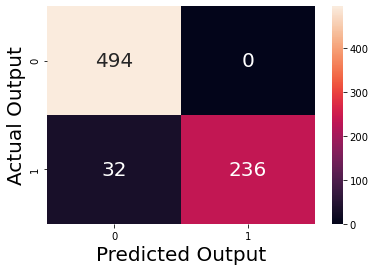

--------------------------------------------
-------------confusion score----------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       494
           1       1.00      0.88      0.94       268

    accuracy                           0.96       762
   macro avg       0.97      0.94      0.95       762
weighted avg       0.96      0.96      0.96       762



In [194]:
result = regressing(X_train = X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Accuracy = (TP+TN) /(TP+FP+FN+TN)
And we have an accuracy of 88%

In [195]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:             converters   No. Observations:                 3045
Model:                          Logit   Df Residuals:                     3013
Method:                           MLE   Df Model:                           31
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                  0.7376
Time:                        15:16:47   Log-Likelihood:                -505.93
converged:                      False   LL-Null:                       -1928.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -3.6146      0.129    -27.977      0.000      -3.868      -3.361
Accordion Clicked                    0.8357      1.097      0.762

## 3.3 Pulling out result

### 3.3.1 Coef

In [167]:
# Fetching the statistics
stat_df=pd.DataFrame({'coefficients':result.params, 'p-value': result.pvalues, 'odds_ratio': np.exp(result.params)})
final = stat_df[['coefficients','p-value']]

final.reset_index(inplace=True)
final.columns = ['event', 'coefficients', 'p-value']

final['coefficients'] = final['coefficients']/3.6146 #normalize with the constante value

#dropped const
final.drop(0, inplace=True)

### 3.3.2 Occurences

In [168]:
df_sampled.reset_index(inplace=True)

In [169]:
df_sampled.head()

EVENT_MODULE,CUSTOMER_ID,Accordion Clicked,Carousel Clicked,Collection Clicked,Color Selected,Email Capture Submitted,Footer Clicked,Homepage Hero Clicked,Language Selected,Load More Reviews,...,Page_visit-us,Product Info Clicked,Product Removed,Review Anchor Clicked,Search Clicked,Search Result Clicked,module_viewed_Featured Products,module_viewed_New Arrivals,module_viewed_Text Image,converters
0,257911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,281411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3800465014807,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3800473567255,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,...,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1
4,3800478384151,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [170]:
df_unpivot = df_sampled.melt(id_vars=['CUSTOMER_ID'], var_name='event_module', value_name = 'occ')
df_unpivot = df_unpivot[df_unpivot['occ']>0.0]

In [171]:
df_occ = df_unpivot[['CUSTOMER_ID', 'event_module']].groupby('event_module').count()

In [172]:
df_occ.reset_index(inplace = True)

In [173]:
df_occ.columns = ['EVENT_MODULE', 'occurences']
sum_occ = df_sampled['CUSTOMER_ID'].count()
print ('number of client = ' + str(sum_occ))
df_occ['% occurence'] = df_occ['occurences'] / sum_occ

number of client = 3807


In [174]:
df_occ = df_occ[df_occ['EVENT_MODULE']!='converters']

In [175]:
df_occ.sort_values('% occurence')

,EVENT_MODULE,occurences,% occurence
31,module_viewed_Text Image,5,0.001313
18,Page_our-story,6,0.001576
17,Page_factory-south-ocean-china,6,0.001576
16,Page_factory-mata-shoes-portugal,9,0.002364
14,Page_black-friday-change,12,0.003152
7,Language Selected,12,0.003152
27,Search Result Clicked,14,0.003677
8,Load More Reviews,18,0.004728
15,Page_contact-us,20,0.005253
19,Page_pricing-philosophy,21,0.005516


### 3.3.3 merge and export

In [176]:
final = final.merge(df_occ, left_on = 'event', right_on = 'EVENT_MODULE')
final.drop('EVENT_MODULE', axis=1, inplace = True)

In [177]:
#export
final.to_csv('event_effect_nolabel_final3.csv')

# don't know what it is

In [54]:
# Condition for significant parameters
significant_params=stat_df[stat_df['p-value']<=0.1].index
significant_params= significant_params.drop('const')
significant_params

KeyError: "['const'] not found in axis"

In [ ]:
print('Total number of parameters: %s '%len(X.keys()) )
print('Number of Significant Parameters: %s'%(len(significant_params)))
final_stat_df = stat_df.loc[significant_params].sort_values('coefficients', ascending=False)['coefficients']
print(final_stat_df)

In [ ]:
event_matrix_NL_final_section = pd.DataFrame(final)
event_matrix_NL_final_section.head()

In [ ]:
event_matrix_NL_final_section.to_excel('event_matrix_NL_final_section.xlsx')